# Defining geometry of the domain with `SpatialTools`

For problems with multiple regions, such as wave generation and absorption zones, and moving obstacles, it's useful to be able to compose the domain from a series of simpler shapes. This approach is implemented by the `proteus.SpatialTools` and `proteus.mprans.SpatialTools` modules.

## Using proteus.mprans.SpatialTools for two-phase flows

In [1]:
%matplotlib notebook
# general imports
from proteus import Domain
from proteus.mprans import SpatialTools as st
import numpy as np
from nbtools import plot_domain, plot_js

The domain is the class that will hold all the geometry defined below. 
Usually, the variable containing the Domain class that will be used for simulations must be called "domain" because the split operator will look specifically for this variable name.
The shapes, boundary conditions, barycenters, etc. are all automatically associated to the domain as long as the shapes were created with the domain passed as an argument.

The available shape classes from proteus.mprans.SpatialTools: CustomShape, Rectangle, Cuboid, Tank2D, Tank3D, ShapeSTL.

Firstly, the domain class instance must be defined and will be used to store the various geometries that the user defines.
We will create 2 domain (2D and 3D) to get an overview of the possible geometries

In [2]:
domain2D = Domain.PlanarStraightLineGraphDomain()
domain3D = Domain.PiecewiseLinearComplexDomain()

### General

In order to define a geometry, the following information must be passed:
 - vertices: list of point coordinates defining the geometry. e.g. `[[x1,y1,z1],[x2,y2,z2]]`
 - segments (2D only): list of list of indices linking 2 vertices. e.g. `[[0,1], [1,2]]`
 - facets (3D only): list of list of a list of indices from several vertices forming a closed area. Can be set clockwise or counterclockwise. e.g. `[[[0,1,2,3]],[[2,3,4,5,6]]]`
 - regions: list of coordinates.
 - holes: list of coordinates (optional).
 - vertexFlags, segmentFlags, facetFlags, regionFlags: list of integer determining boundary conditions. e.g. `[1,1,2,3,3,3]`

### Custom shapes

Custom shapes need a boundary tags dictionary (used for flagging elements), vertices, segments (or facets in 3D), and their respective flags that will be used for boundary conditions.

In [3]:
my_vertices = [[0., 0.], [2., 0.], [8., 0.], [10., 0.],
               [10., 5.], [8., 5.], [2., 5.], [0., 5.]]
my_segments = [[0, 1], [1, 2], [2, 3], [3, 4], 
               [4, 5], [5, 6], [6, 7], [7, 0],
               [1, 7], [2, 6]]

The number of entries in the boundaryTags dictionary gives the number of different boundary condition class instances on the shape. The values of the dictionary should always consist of a list of integers starting from 1 and incrementing by 1. The flags are used to tell which vertex/segment/facet gets which boundary condition.

In [4]:
# boundary tags dictionary
bt = {'bottom': 1, 'right': 2, 'top': 3, 'left': 4, 'sponge': 5}

# the number of flags must be the same as the number of vertices defined above
my_vertexFlags = [bt['bottom'], bt['bottom'], bt['bottom'], bt['bottom'],
                  bt['top'], bt['top'], bt['top'], bt['top'],
                  bt['sponge'], bt['sponge']]

# flags can be defined directly with the values in the dictionary
my_segmentFlags = [1, 1, 1, 2, 3, 3, 3, 4, 5, 5]

Regions are defined by giving the coordinates of a point within an area enclosed by segments/facets. It does not matter where the point lies within the region as long as it is inside a space enclosed by segments (or facets).

Region flags have no link with the boundary tag dictionary defined above and will be used for regional boundary conditions.

In [5]:
my_regions = [[1., 1.], [5., 1.], [9., 1.]]
my_regionFlags = [2, 1, 3]

Create the custom shape. The domain must always be passed in order to add the geometry to the domain's shape list

In [6]:
my_custom = st.CustomShape(domain2D, boundaryTags=bt, 
                           vertices=my_vertices, vertexFlags=my_vertexFlags,
                           segments=my_segments, segmentFlags=my_segmentFlags, 
                           regions=my_regions, regionFlags=my_regionFlags)

### Predefined Shapes

#### Rectangle

In [7]:
my_rectangle = st.Rectangle(domain2D, dim=[1., 1.], coords=[2., 2.])

print(my_rectangle.boundaryTags)

{'y-': 1, 'x+': 2, 'y+': 3, 'x-': 4}


#### Cuboid

In [8]:
my_cuboid = st.Cuboid(domain3D, dim=[1., 1., 1.], coords=[2.,2.,2.])

#### Tank classes
The tank class, (based on the Rectangle or Cuboid classes) makes it easier to define absorption/generation/porous zones.

(!) this class should not be rotated.

In [9]:
my_tank = st.Tank2D(domain2D, dim=[20., 10.])
my_tank.setSponge(x_n=2., x_p=2.)
# (!) the dimension of the tank should be large enough to accomodate the sponge layers as those are added inwards

### STL Shapes

In [10]:
domainSTL = Domain.PiecewiseLinearComplexDomain()
my_stl = st.ShapeSTL(domainSTL, 'wind-turbine.stl')
my_stl2 = st.ShapeSTL(domainSTL, 'wind-turbine.stl')
my_stl2.translate([4000., 5000., 0.])
my_stl3 = st.ShapeSTL(domainSTL, 'wind-turbine.stl')
my_stl3.translate([8000., 2000., 0.])

print('number of vertices: {0:d}'.format(len(my_stl.vertices)+len(my_stl2.vertices)+len(my_stl3.vertices)))

number of vertices: 104262


<IPython.core.display.Javascript object>


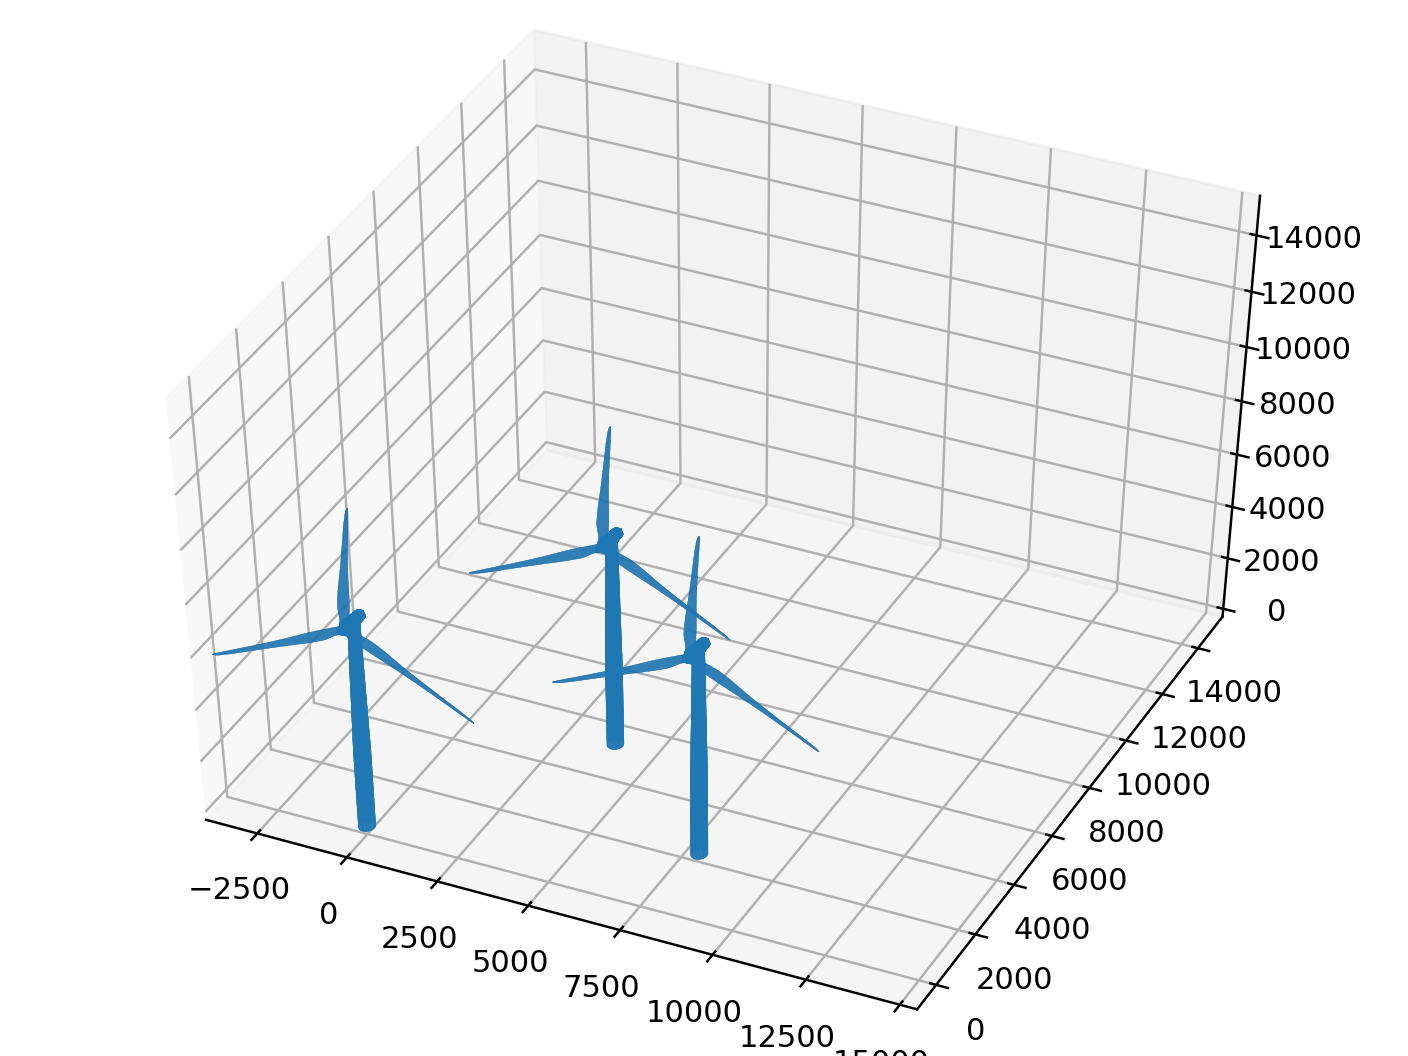

In [11]:
plot_domain(domainSTL, azim=-65, elev=45)

## Transforming Geometries

Shapes can be easily moved and rotated. This will affect: vertices, regions, holes, coords (if not None), barycenters for rotation and translation as well as local coordinate system and boundary orientations for rotation only.

*note: if the pivot point is not passed as an argument for rotation, the shape will rotate around its barycenter (if defined, otherwise around the origin [0., 0.])*

In [12]:
my_rectangle.rotate(np.pi/12., pivot=[2., 2.])
my_custom.translate([5., 1.])

my_cuboid.rotate(np.pi/6., pivot=[2., 2., 2.], axis=[1., 1., 0.])

# for setPosition(), the barycenter must first be set.
# we will use the "coords" variable of the predefined shape (center of rectangle)
my_rectangle.setBarycenter(my_rectangle.coords)
my_rectangle.setPosition([4., 2.])

<IPython.core.display.Javascript object>


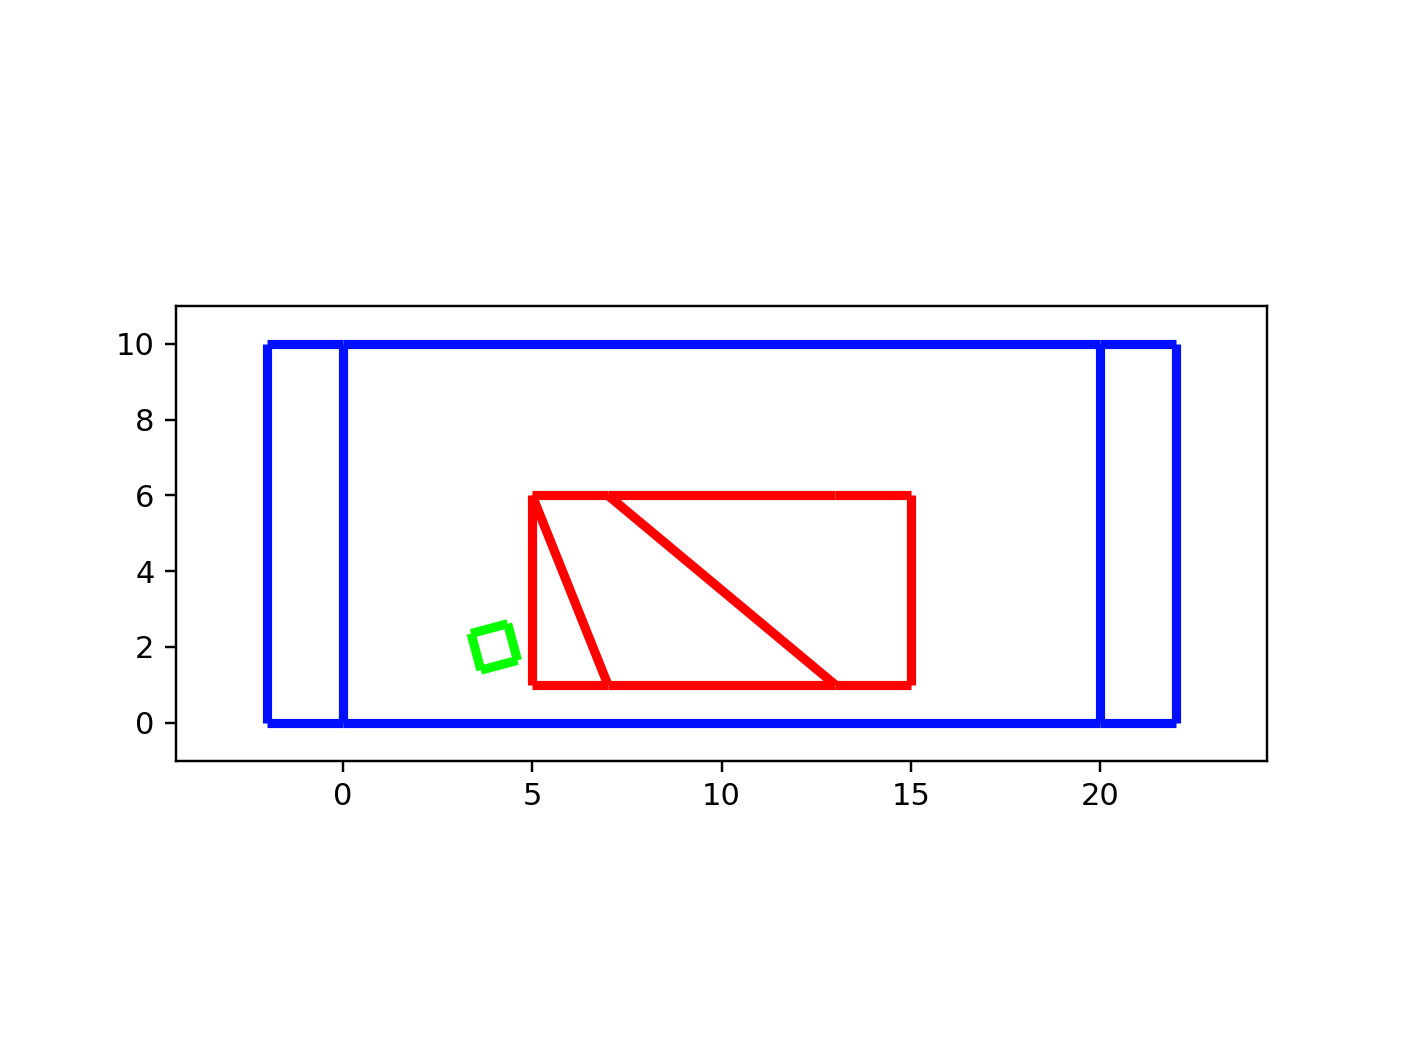

In [13]:
plot_domain(domain2D)

## Making a Rigid Body

The necessary variables for displacement from force and moments are defined.

*note: the inertia tensor will be multiplied by the mass for angular acceleration calculations*

In [14]:
my_rectangle.setBarycenter([2., 2.])
my_rectangle.mass = 2. #.setMass(2.)
my_rectangle.It = 0.4

Finally, the following line will create an auxiliary variable that will receive information from the model at each time step (in this case: pressure and shear forces, and moments) and calculate its displacement. It also sets the moving mesh boundary condition automatically, making all nodes on the segments/facets move with the shape.

Setting a rigid body also imposes boundary conditions for moving mesh with the displacement of the nodes imposed with dirichlet conditions as follows:
$$
\begin{eqnarray}
\text{disp}(\mathbf{x}^n) = R^{n+1}\cdot\left( \mathbf{x}^n-\mathbf{x}^n_{\text{pivot}}\right) - (\mathbf{x}^n-\mathbf{x}^n_{\text{pivot}})+h^{n+1} \\
\mathbf{x}^{n+1} = \mathbf{x}^n+\text{disp}(\mathbf{x}^n)
\end{eqnarray}
$$

### Assembling the domain

The domain should be assembled after all geometries as well as their auxiliary variables have been defined, including absorption/generation/porous zones which a regional boundary conditions (see BoundaryConditions tutorial).

<IPython.core.display.Javascript object>


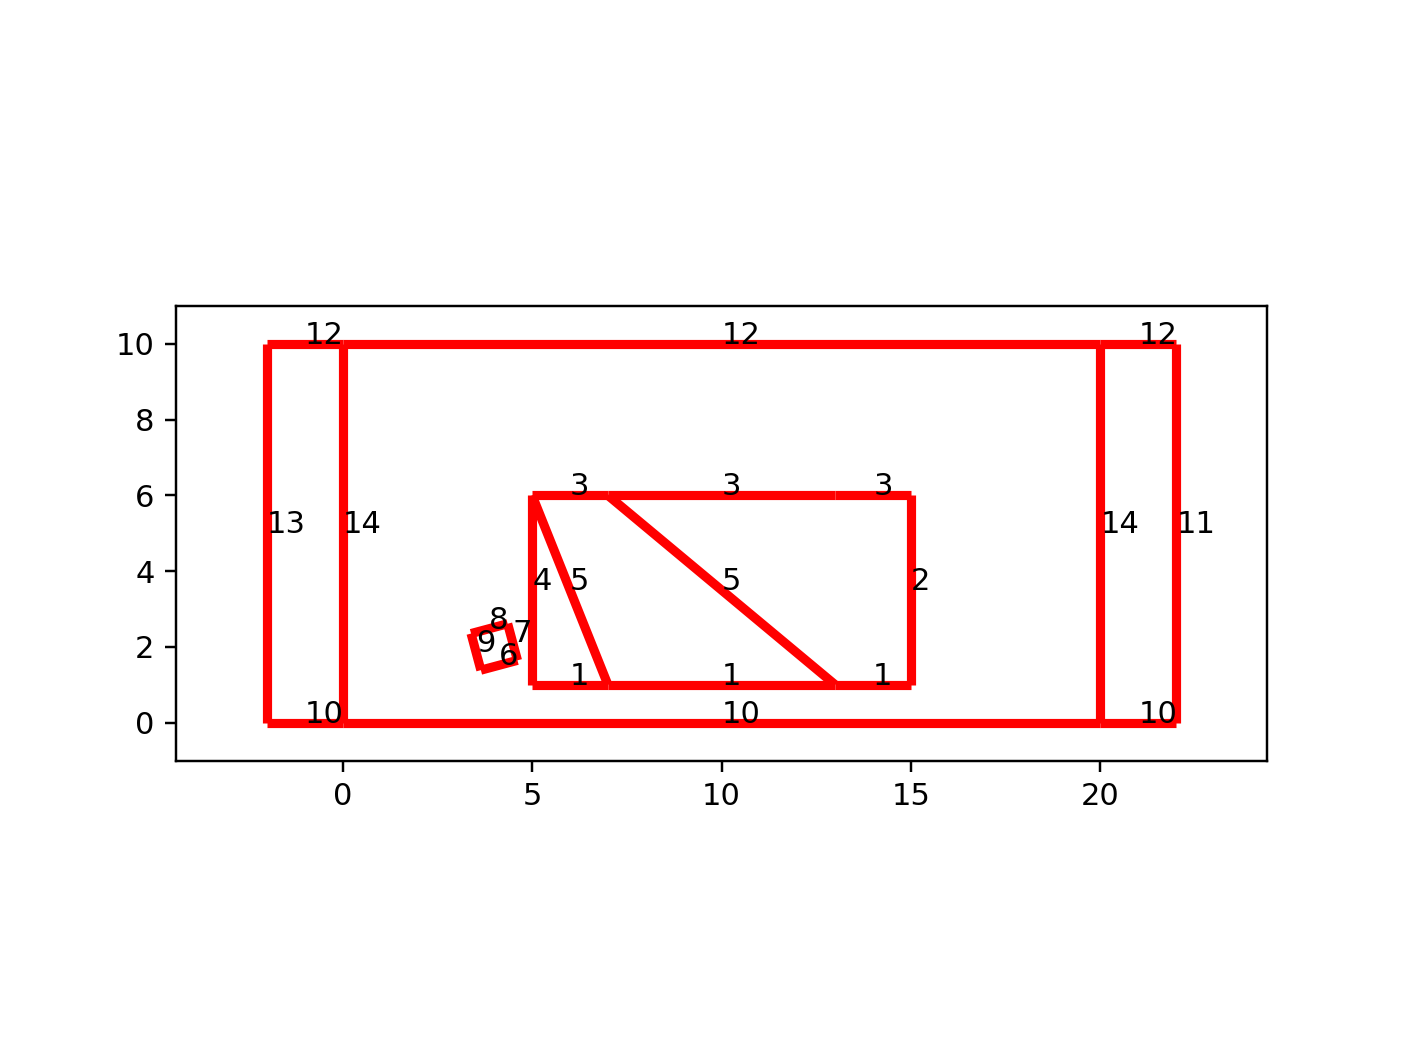

In [15]:
st.assembleDomain(domain2D)

plot_domain(domain2D, flags='global')

In [16]:
'Segment flags'
for i, shape in enumerate(domain2D.shape_list):
    print('shape '+str(i+1)+':', shape.segmentFlags.tolist())
print('domain', domain2D.segmentFlags)
print('number of boundary conditions:',len(domain2D.bc))

shape 1: [1, 1, 1, 2, 3, 3, 3, 4, 5, 5]
shape 2: [1, 2, 3, 4]
shape 3: [1, 5, 3, 5, 1, 4, 3, 1, 2, 3]
domain [1, 1, 1, 2, 3, 3, 3, 4, 5, 5, 6, 7, 8, 9, 10, 14, 12, 14, 10, 13, 12, 10, 11, 12]
number of boundary conditions: 15
